# EDA: gt_service_name（Google Trends 検索数データ）

## 目的
Google Trendsの検索数データ（週次）を多角的に分析し、入電数との関係性を探る

## 分析視点
1. 基本統計量・分布
2. 時系列トレンド
3. 季節性・周期性
4. 入電数との相関分析
5. ラグ分析（時差相関）
6. 異常値・外れ値検出
7. イベント影響分析（消費税改定など）
8. 予測への有用性評価

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'MS Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (14, 6)

print('ライブラリ読み込み完了')

ライブラリ読み込み完了


In [2]:
# ==================================================================================
# データ読み込み
# ==================================================================================

# Google Trends データ（週次）
gt_df = pd.read_csv('../input/gt_service_name.csv')
gt_df['week'] = pd.to_datetime(gt_df['week'])

# 入電数データ（日次）
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])

print("【gt_service_name.csv】")
print(f"  期間: {gt_df['week'].min()} ~ {gt_df['week'].max()}")
print(f"  レコード数: {len(gt_df)}")
print(f"  カラム: {gt_df.columns.tolist()}")

print("\n【regi_call_data_transform.csv】")
print(f"  期間: {call_df['cdr_date'].min()} ~ {call_df['cdr_date'].max()}")
print(f"  レコード数: {len(call_df)}")

【gt_service_name.csv】
  期間: 2018-03-04 00:00:00 ~ 2020-03-29 00:00:00
  レコード数: 109
  カラム: ['week', 'search_cnt']

【regi_call_data_transform.csv】
  期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00
  レコード数: 670


---
## 1. 基本統計量・分布

In [3]:
# ==================================================================================
# 基本統計量
# ==================================================================================

print("="*60)
print("基本統計量")
print("="*60)
print(gt_df['search_cnt'].describe())

print(f"\n【追加統計量】")
print(f"  中央値:     {gt_df['search_cnt'].median():.1f}")
print(f"  最頻値:     {gt_df['search_cnt'].mode().values[0]}")
print(f"  歪度:       {gt_df['search_cnt'].skew():.3f}")
print(f"  尖度:       {gt_df['search_cnt'].kurtosis():.3f}")
print(f"  変動係数:   {gt_df['search_cnt'].std() / gt_df['search_cnt'].mean() * 100:.1f}%")
print(f"  四分位範囲: {gt_df['search_cnt'].quantile(0.75) - gt_df['search_cnt'].quantile(0.25):.1f}")

基本統計量
count    109.000000
mean      35.348624
std       17.573853
min        6.000000
25%       24.000000
50%       32.000000
75%       46.000000
max      100.000000
Name: search_cnt, dtype: float64

【追加統計量】
  中央値:     32.0
  最頻値:     25
  歪度:       0.885
  尖度:       1.408
  変動係数:   49.7%
  四分位範囲: 22.0


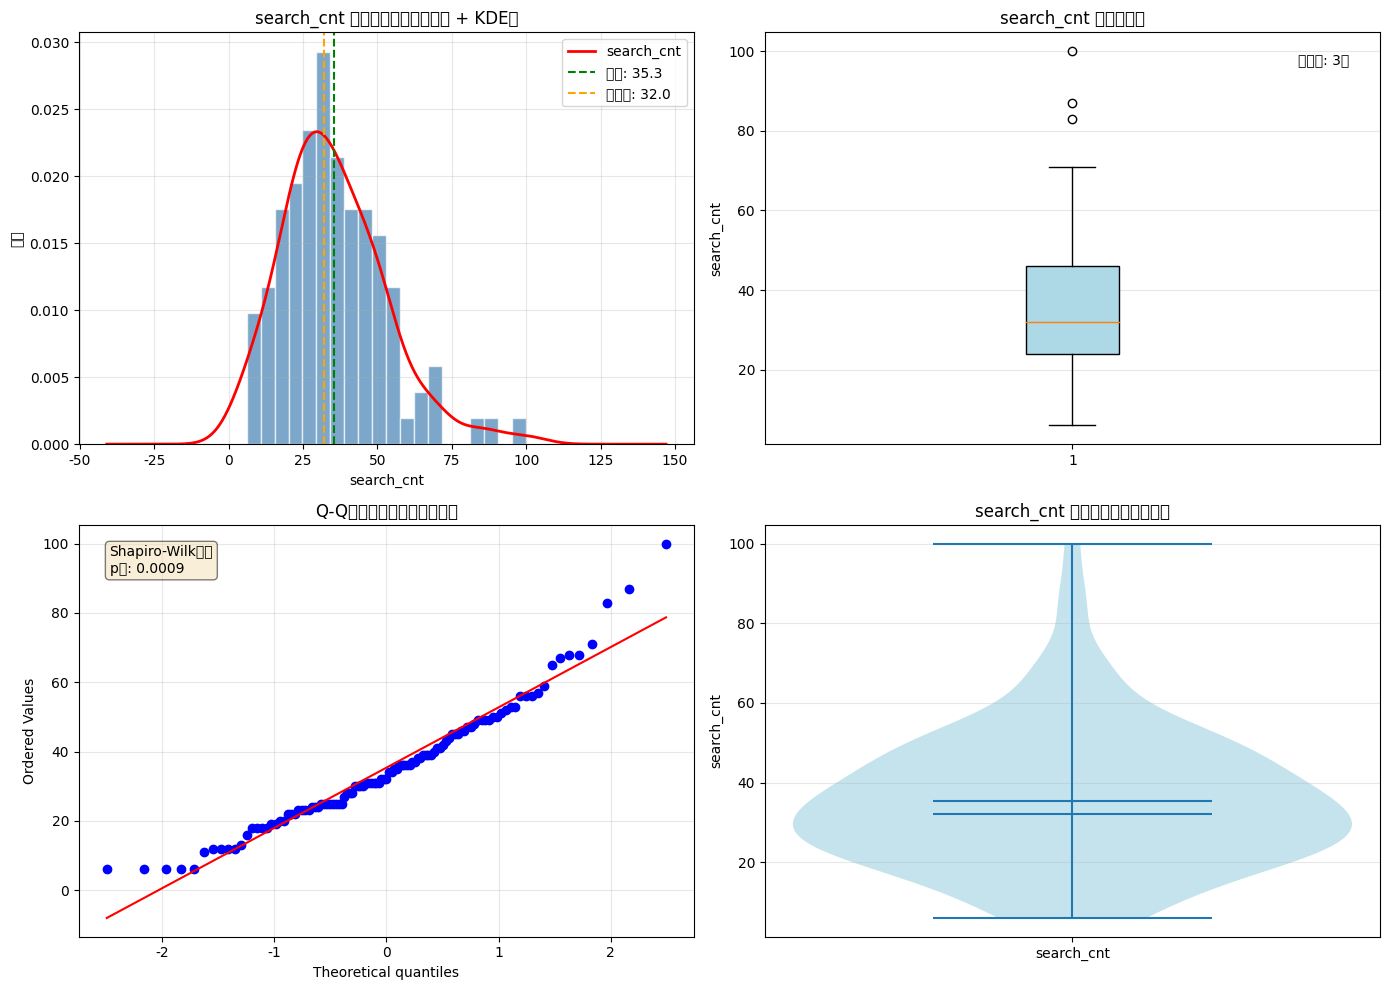

In [4]:
# ==================================================================================
# 分布の可視化
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ヒストグラム + KDE
ax = axes[0, 0]
ax.hist(gt_df['search_cnt'], bins=20, density=True, alpha=0.7, color='steelblue', edgecolor='white')
gt_df['search_cnt'].plot.kde(ax=ax, color='red', linewidth=2)
ax.axvline(gt_df['search_cnt'].mean(), color='green', linestyle='--', label=f'平均: {gt_df["search_cnt"].mean():.1f}')
ax.axvline(gt_df['search_cnt'].median(), color='orange', linestyle='--', label=f'中央値: {gt_df["search_cnt"].median():.1f}')
ax.set_xlabel('search_cnt')
ax.set_ylabel('密度')
ax.set_title('search_cnt の分布（ヒストグラム + KDE）')
ax.legend()
ax.grid(alpha=0.3)

# 2. 箱ひげ図
ax = axes[0, 1]
bp = ax.boxplot(gt_df['search_cnt'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax.set_ylabel('search_cnt')
ax.set_title('search_cnt の箱ひげ図')
ax.grid(alpha=0.3, axis='y')

# 外れ値の情報
q1 = gt_df['search_cnt'].quantile(0.25)
q3 = gt_df['search_cnt'].quantile(0.75)
iqr = q3 - q1
outliers = gt_df[(gt_df['search_cnt'] < q1 - 1.5*iqr) | (gt_df['search_cnt'] > q3 + 1.5*iqr)]
ax.text(0.95, 0.95, f'外れ値: {len(outliers)}件', transform=ax.transAxes, ha='right', va='top', fontsize=10)

# 3. Q-Qプロット（正規性検定）
ax = axes[1, 0]
stats.probplot(gt_df['search_cnt'], dist='norm', plot=ax)
ax.set_title('Q-Qプロット（正規性検定）')
ax.grid(alpha=0.3)

# Shapiro-Wilk検定
stat, p_value = stats.shapiro(gt_df['search_cnt'])
ax.text(0.05, 0.95, f'Shapiro-Wilk検定\np値: {p_value:.4f}', transform=ax.transAxes, ha='left', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. バイオリンプロット
ax = axes[1, 1]
parts = ax.violinplot(gt_df['search_cnt'], positions=[1], showmeans=True, showmedians=True)
parts['bodies'][0].set_facecolor('lightblue')
parts['bodies'][0].set_alpha(0.7)
ax.set_ylabel('search_cnt')
ax.set_title('search_cnt のバイオリンプロット')
ax.set_xticks([1])
ax.set_xticklabels(['search_cnt'])
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../output/eda_gt_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 2. 時系列トレンド

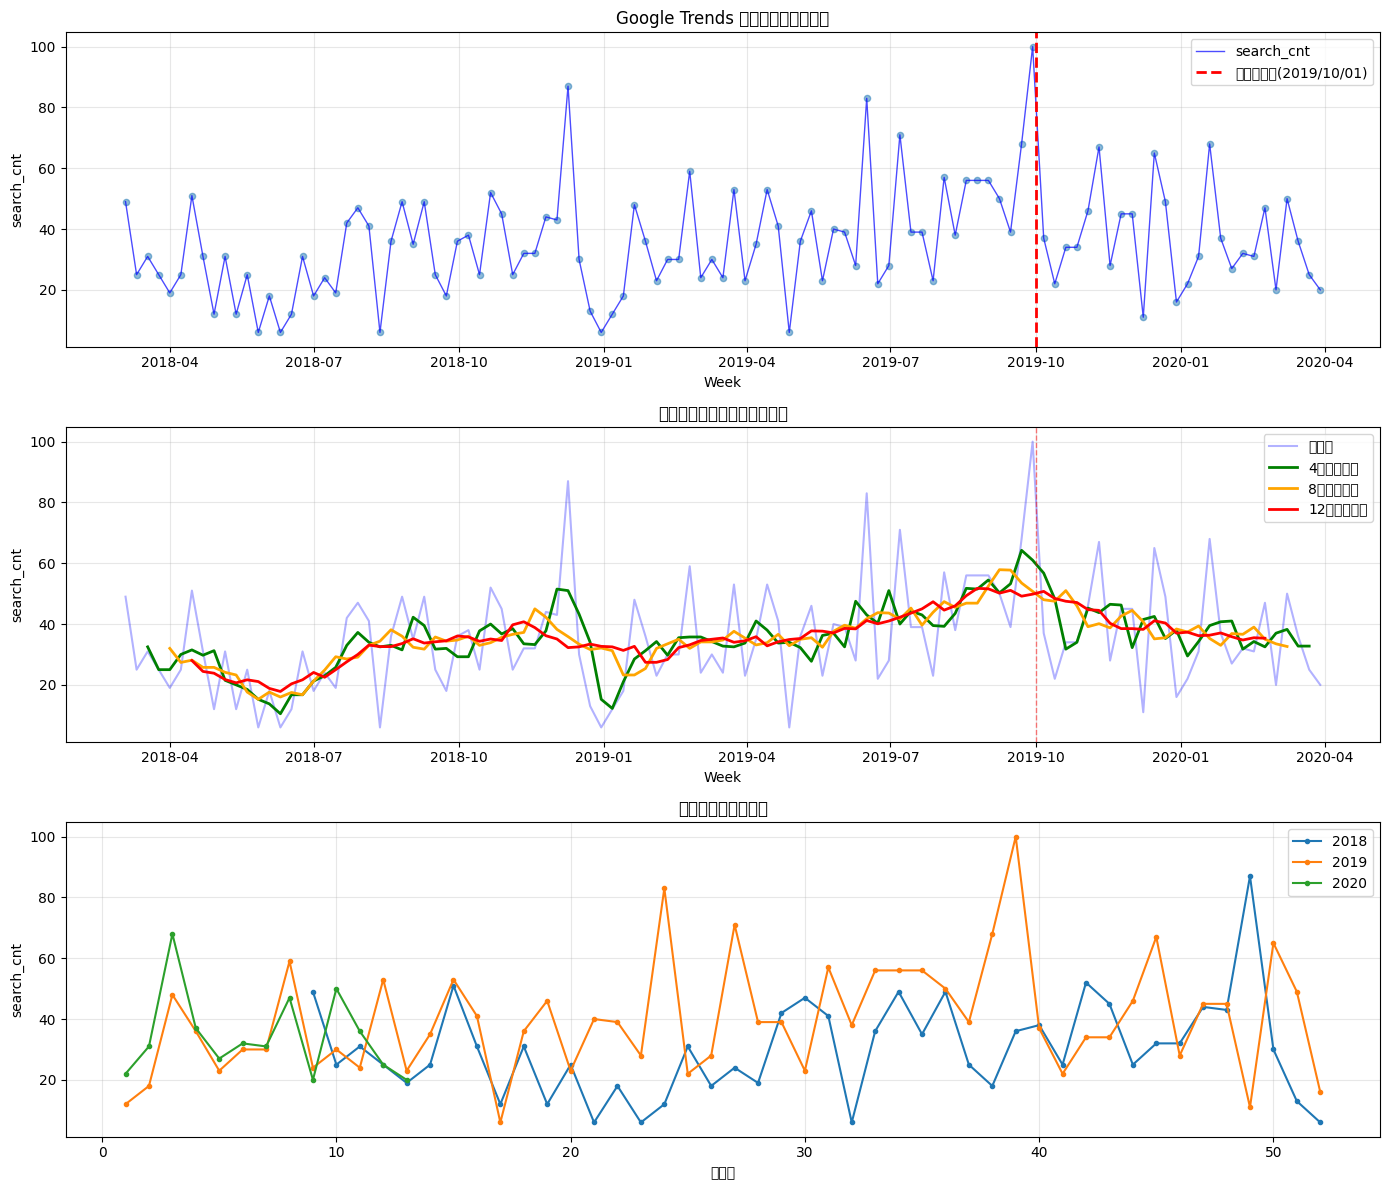

In [5]:
# ==================================================================================
# 時系列プロット
# ==================================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. 基本時系列
ax = axes[0]
ax.plot(gt_df['week'], gt_df['search_cnt'], 'b-', linewidth=1, alpha=0.7, label='search_cnt')
ax.scatter(gt_df['week'], gt_df['search_cnt'], s=20, alpha=0.5)
ax.set_xlabel('Week')
ax.set_ylabel('search_cnt')
ax.set_title('Google Trends 検索数の時系列推移')
ax.legend()
ax.grid(alpha=0.3)

# 消費税改定日をマーク
tax_date = pd.Timestamp('2019-10-01')
ax.axvline(tax_date, color='red', linestyle='--', linewidth=2, label='消費税改定(2019/10/01)')
ax.legend()

# 2. 移動平均トレンド
ax = axes[1]
gt_df['ma_4'] = gt_df['search_cnt'].rolling(window=4, center=True).mean()
gt_df['ma_8'] = gt_df['search_cnt'].rolling(window=8, center=True).mean()
gt_df['ma_12'] = gt_df['search_cnt'].rolling(window=12, center=True).mean()

ax.plot(gt_df['week'], gt_df['search_cnt'], 'b-', alpha=0.3, label='原系列')
ax.plot(gt_df['week'], gt_df['ma_4'], 'g-', linewidth=2, label='4週移動平均')
ax.plot(gt_df['week'], gt_df['ma_8'], 'orange', linewidth=2, label='8週移動平均')
ax.plot(gt_df['week'], gt_df['ma_12'], 'r-', linewidth=2, label='12週移動平均')
ax.axvline(tax_date, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Week')
ax.set_ylabel('search_cnt')
ax.set_title('移動平均によるトレンド分析')
ax.legend()
ax.grid(alpha=0.3)

# 3. 前年同期比較
ax = axes[2]
gt_df['year'] = gt_df['week'].dt.year
gt_df['week_of_year'] = gt_df['week'].dt.isocalendar().week

for year in gt_df['year'].unique():
    year_data = gt_df[gt_df['year'] == year]
    ax.plot(year_data['week_of_year'], year_data['search_cnt'], marker='o', markersize=3, label=str(year))

ax.set_xlabel('週番号')
ax.set_ylabel('search_cnt')
ax.set_title('年別の週次推移比較')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

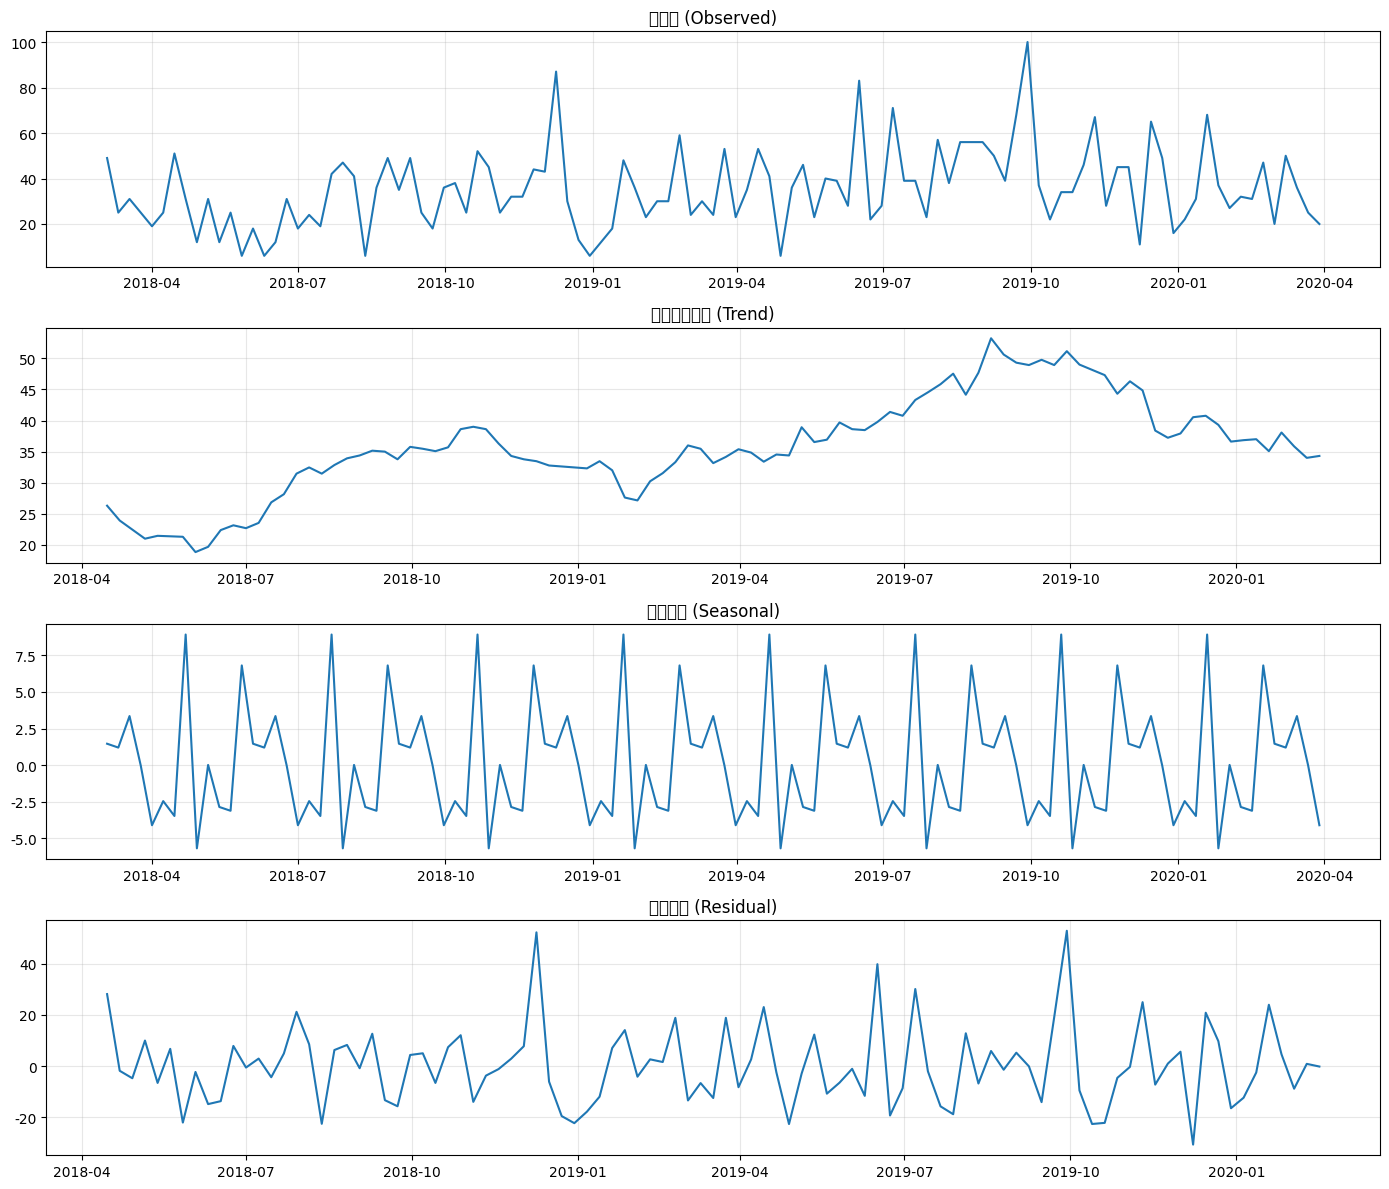


【トレンド分解の結果】
  季節成分の振幅: 14.6
  残差の標準偏差: 15.48


In [6]:
# ==================================================================================
# トレンド分解（季節性・トレンド・残差）
# ==================================================================================

from statsmodels.tsa.seasonal import seasonal_decompose

# 週次データなので period=52（1年）
# データが短いので period=13（四半期）で試す
decomposition = seasonal_decompose(gt_df['search_cnt'], model='additive', period=13)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(gt_df['week'], decomposition.observed)
axes[0].set_title('原系列 (Observed)')
axes[0].grid(alpha=0.3)

axes[1].plot(gt_df['week'], decomposition.trend)
axes[1].set_title('トレンド成分 (Trend)')
axes[1].grid(alpha=0.3)

axes[2].plot(gt_df['week'], decomposition.seasonal)
axes[2].set_title('季節成分 (Seasonal)')
axes[2].grid(alpha=0.3)

axes[3].plot(gt_df['week'], decomposition.resid)
axes[3].set_title('残差成分 (Residual)')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n【トレンド分解の結果】")
print(f"  季節成分の振幅: {decomposition.seasonal.max() - decomposition.seasonal.min():.1f}")
print(f"  残差の標準偏差: {decomposition.resid.std():.2f}")

---
## 3. 季節性・周期性

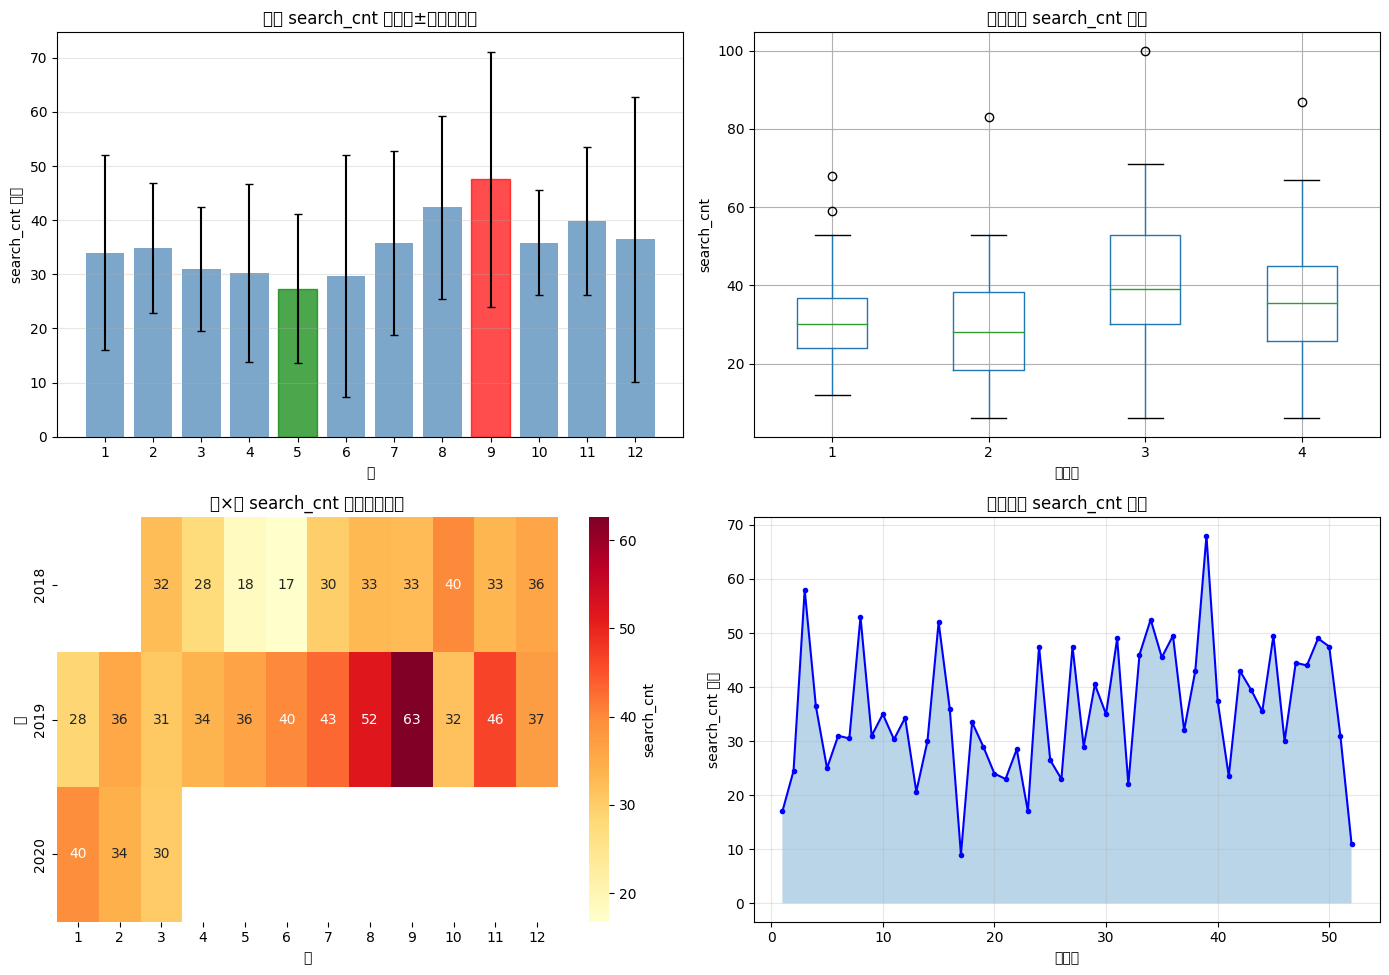


【季節性の統計】
  検索数が最も多い月:   9月 (平均: 47.6)
  検索数が最も少ない月: 5月 (平均: 27.4)


In [7]:
# ==================================================================================
# 月別・四半期別分析
# ==================================================================================

gt_df['month'] = gt_df['week'].dt.month
gt_df['quarter'] = gt_df['week'].dt.quarter
gt_df['month_name'] = gt_df['week'].dt.month_name()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 月別平均
ax = axes[0, 0]
monthly_avg = gt_df.groupby('month')['search_cnt'].agg(['mean', 'std']).reset_index()
bars = ax.bar(monthly_avg['month'], monthly_avg['mean'], yerr=monthly_avg['std'], 
              capsize=3, color='steelblue', alpha=0.7)
ax.set_xlabel('月')
ax.set_ylabel('search_cnt 平均')
ax.set_title('月別 search_cnt 平均（±標準偏差）')
ax.set_xticks(range(1, 13))
ax.grid(alpha=0.3, axis='y')

# 最大・最小の月をハイライト
max_month = monthly_avg.loc[monthly_avg['mean'].idxmax(), 'month']
min_month = monthly_avg.loc[monthly_avg['mean'].idxmin(), 'month']
bars[int(max_month)-1].set_color('red')
bars[int(min_month)-1].set_color('green')

# 2. 四半期別箱ひげ図
ax = axes[0, 1]
gt_df.boxplot(column='search_cnt', by='quarter', ax=ax)
ax.set_xlabel('四半期')
ax.set_ylabel('search_cnt')
ax.set_title('四半期別 search_cnt 分布')
plt.suptitle('')

# 3. 月別ヒートマップ
ax = axes[1, 0]
pivot_data = gt_df.pivot_table(values='search_cnt', index='year', columns='month', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'search_cnt'})
ax.set_xlabel('月')
ax.set_ylabel('年')
ax.set_title('年×月 search_cnt ヒートマップ')

# 4. 週番号別平均
ax = axes[1, 1]
weekly_avg = gt_df.groupby('week_of_year')['search_cnt'].mean()
ax.plot(weekly_avg.index, weekly_avg.values, 'b-', marker='o', markersize=3)
ax.fill_between(weekly_avg.index, 0, weekly_avg.values, alpha=0.3)
ax.set_xlabel('週番号')
ax.set_ylabel('search_cnt 平均')
ax.set_title('週番号別 search_cnt 平均')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_seasonality.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n【季節性の統計】")
print(f"  検索数が最も多い月:   {int(max_month)}月 (平均: {monthly_avg.loc[monthly_avg['month']==max_month, 'mean'].values[0]:.1f})")
print(f"  検索数が最も少ない月: {int(min_month)}月 (平均: {monthly_avg.loc[monthly_avg['month']==min_month, 'mean'].values[0]:.1f})")

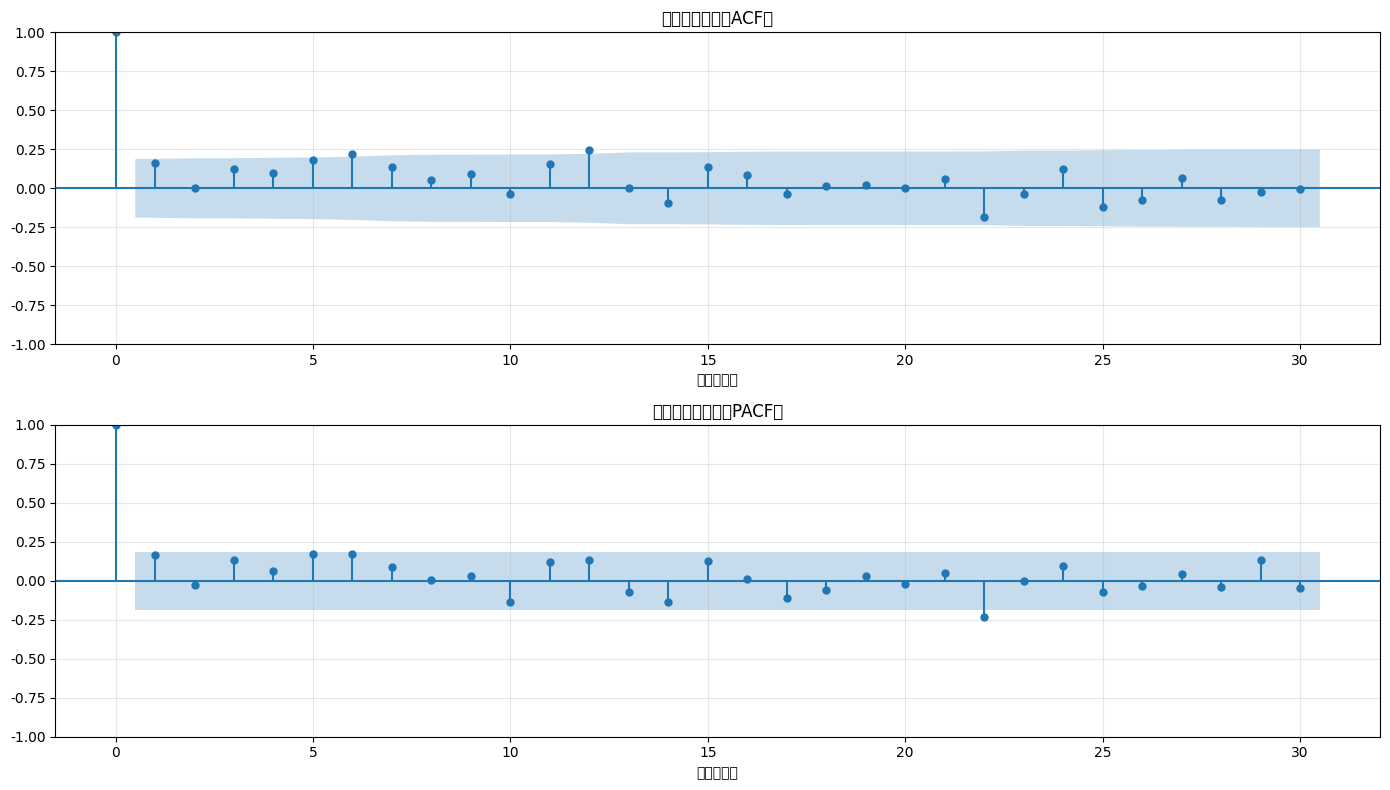

In [8]:
# ==================================================================================
# 自己相関分析（周期性の検出）
# ==================================================================================

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 自己相関関数（ACF）
plot_acf(gt_df['search_cnt'], lags=30, ax=axes[0], alpha=0.05)
axes[0].set_title('自己相関関数（ACF）')
axes[0].set_xlabel('ラグ（週）')
axes[0].grid(alpha=0.3)

# 偏自己相関関数（PACF）
plot_pacf(gt_df['search_cnt'], lags=30, ax=axes[1], alpha=0.05)
axes[1].set_title('偏自己相関関数（PACF）')
axes[1].set_xlabel('ラグ（週）')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_autocorrelation.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. 入電数との相関分析

In [9]:
# ==================================================================================
# 日次データへの展開とマージ
# ==================================================================================

# Google Trendsデータを日次に展開
gt_daily_list = []
for idx, row in gt_df.iterrows():
    week_start = row['week']
    for i in range(7):
        date = week_start + timedelta(days=i)
        gt_daily_list.append({'cdr_date': date, 'search_cnt': row['search_cnt']})

gt_daily = pd.DataFrame(gt_daily_list)

# 入電数データとマージ
merged_df = call_df.merge(gt_daily, on='cdr_date', how='inner')

# 平日のみ（土日除外）
merged_df['dow'] = merged_df['cdr_date'].dt.dayofweek
merged_df_weekday = merged_df[merged_df['dow'] < 5].copy()

print(f"マージ後データ数: {len(merged_df)}")
print(f"平日のみ: {len(merged_df_weekday)}")

マージ後データ数: 670
平日のみ: 478


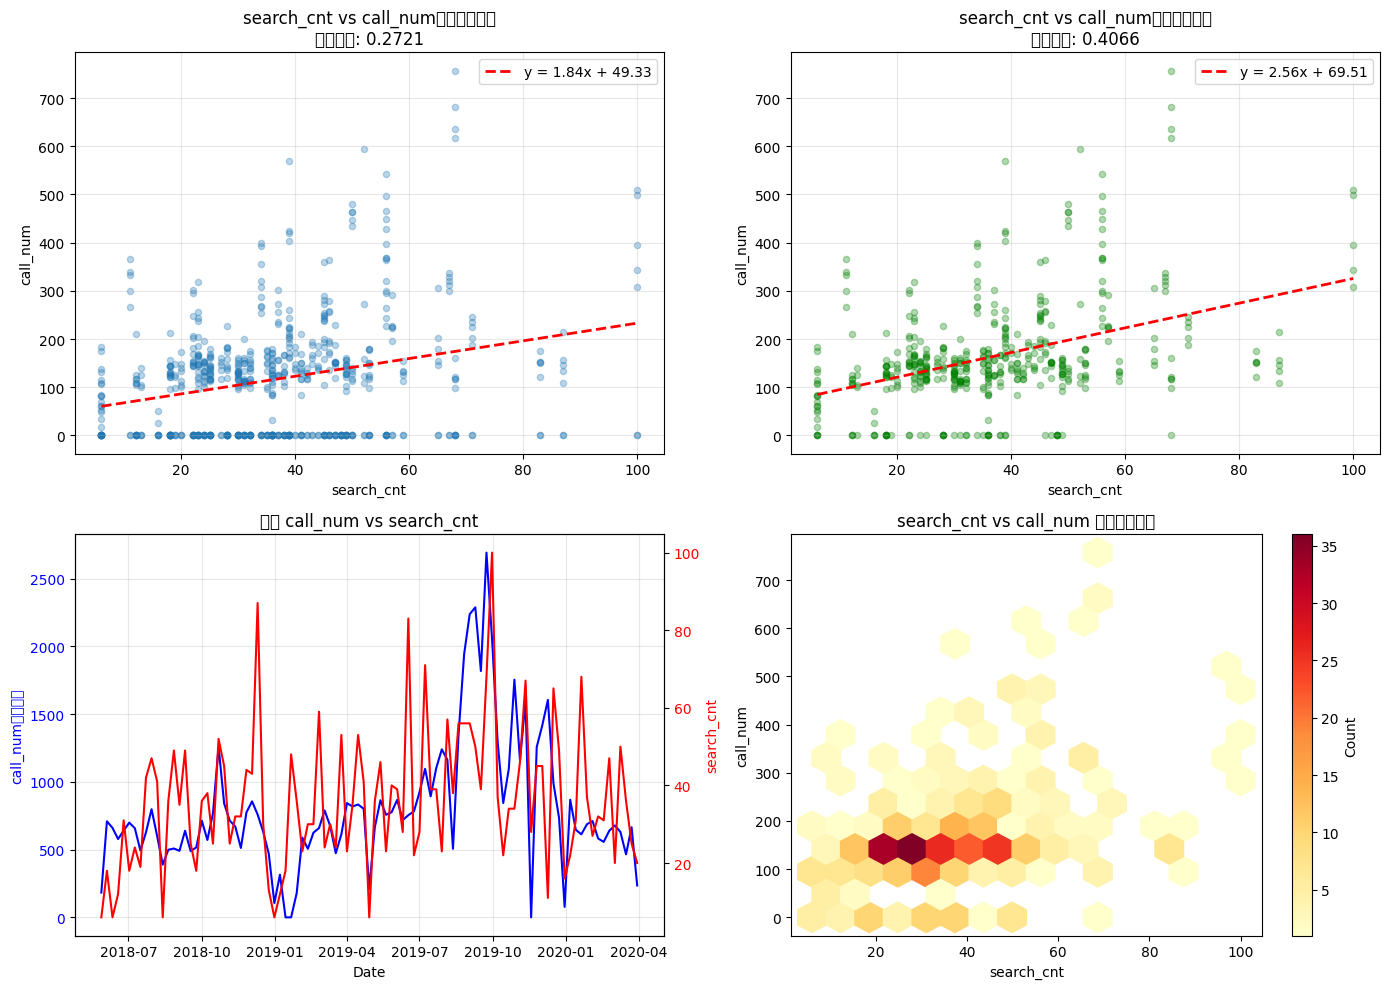


【相関係数】
  全データ: 0.2721
  平日のみ: 0.4066


In [10]:
# ==================================================================================
# 相関分析
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 散布図（全データ）
ax = axes[0, 0]
ax.scatter(merged_df['search_cnt'], merged_df['call_num'], alpha=0.3, s=20)
corr_all = merged_df['search_cnt'].corr(merged_df['call_num'])
ax.set_xlabel('search_cnt')
ax.set_ylabel('call_num')
ax.set_title(f'search_cnt vs call_num（全データ）\n相関係数: {corr_all:.4f}')
ax.grid(alpha=0.3)

# 回帰直線
z = np.polyfit(merged_df['search_cnt'], merged_df['call_num'], 1)
p = np.poly1d(z)
x_line = np.linspace(merged_df['search_cnt'].min(), merged_df['search_cnt'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
ax.legend()

# 2. 散布図（平日のみ）
ax = axes[0, 1]
ax.scatter(merged_df_weekday['search_cnt'], merged_df_weekday['call_num'], alpha=0.3, s=20, color='green')
corr_weekday = merged_df_weekday['search_cnt'].corr(merged_df_weekday['call_num'])
ax.set_xlabel('search_cnt')
ax.set_ylabel('call_num')
ax.set_title(f'search_cnt vs call_num（平日のみ）\n相関係数: {corr_weekday:.4f}')
ax.grid(alpha=0.3)

# 回帰直線
z = np.polyfit(merged_df_weekday['search_cnt'], merged_df_weekday['call_num'], 1)
p = np.poly1d(z)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
ax.legend()

# 3. 時系列比較（二軸）
ax = axes[1, 0]
ax2 = ax.twinx()

# 週次に集計
merged_df['week_start'] = merged_df['cdr_date'] - pd.to_timedelta(merged_df['cdr_date'].dt.dayofweek, unit='D')
weekly_call = merged_df.groupby('week_start')['call_num'].sum().reset_index()
weekly_search = merged_df.groupby('week_start')['search_cnt'].first().reset_index()

ax.plot(weekly_call['week_start'], weekly_call['call_num'], 'b-', label='call_num（週計）', linewidth=1.5)
ax2.plot(weekly_search['week_start'], weekly_search['search_cnt'], 'r-', label='search_cnt', linewidth=1.5)

ax.set_xlabel('Date')
ax.set_ylabel('call_num（週計）', color='blue')
ax2.set_ylabel('search_cnt', color='red')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
ax.set_title('週次 call_num vs search_cnt')
ax.grid(alpha=0.3)

# 4. Hexbinプロット（密度）
ax = axes[1, 1]
hb = ax.hexbin(merged_df_weekday['search_cnt'], merged_df_weekday['call_num'], 
               gridsize=15, cmap='YlOrRd', mincnt=1)
ax.set_xlabel('search_cnt')
ax.set_ylabel('call_num')
ax.set_title('search_cnt vs call_num 密度プロット')
plt.colorbar(hb, ax=ax, label='Count')

plt.tight_layout()
plt.savefig('../output/eda_gt_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n【相関係数】")
print(f"  全データ: {corr_all:.4f}")
print(f"  平日のみ: {corr_weekday:.4f}")

---
## 5. ラグ分析（時差相関）

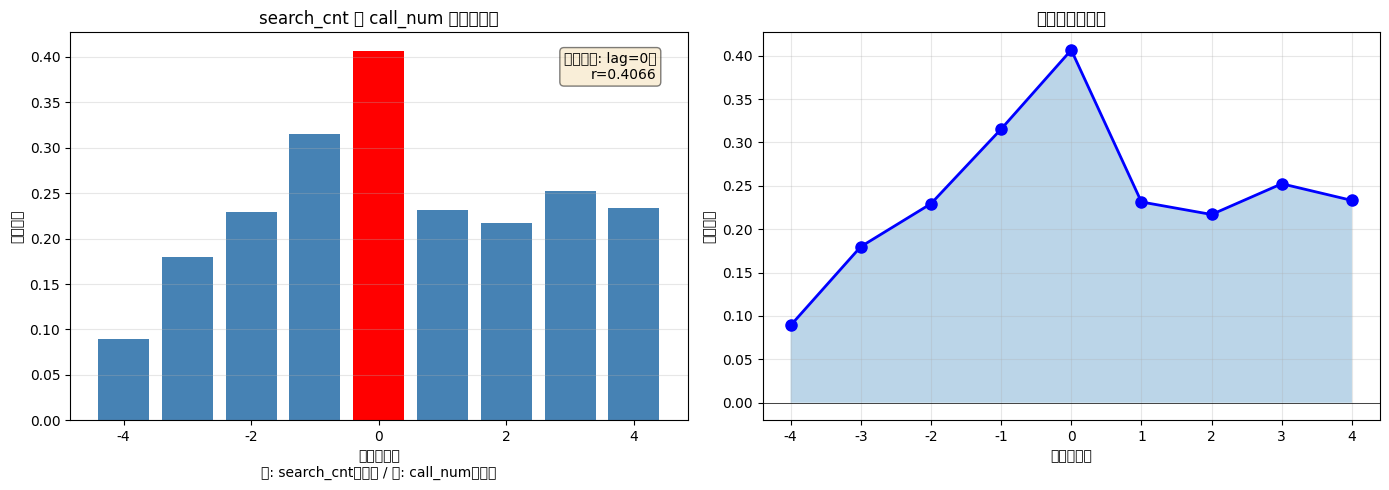


【ラグ相関の結果】
 lag_weeks  correlation
        -4     0.089112
        -3     0.179894
        -2     0.229390
        -1     0.315400
         0     0.406622
         1     0.231430
         2     0.216985
         3     0.252410
         4     0.233206


In [11]:
# ==================================================================================
# ラグ相関分析
# ==================================================================================

# search_cntと将来のcall_numの相関を計算
# 「今週の検索数」が「X週後の入電数」とどの程度相関するか

lag_correlations = []

for lag in range(-4, 5):  # -4週から+4週まで
    merged_df_weekday[f'call_num_lag{lag}'] = merged_df_weekday['call_num'].shift(-lag * 5)  # 5営業日 = 1週間
    corr = merged_df_weekday['search_cnt'].corr(merged_df_weekday[f'call_num_lag{lag}'])
    lag_correlations.append({'lag_weeks': lag, 'correlation': corr})

lag_corr_df = pd.DataFrame(lag_correlations)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. ラグ相関プロット
ax = axes[0]
colors = ['red' if c == lag_corr_df['correlation'].max() else 'steelblue' for c in lag_corr_df['correlation']]
bars = ax.bar(lag_corr_df['lag_weeks'], lag_corr_df['correlation'], color=colors)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('ラグ（週）\n負: search_cntが先行 / 正: call_numが先行')
ax.set_ylabel('相関係数')
ax.set_title('search_cnt と call_num のラグ相関')
ax.grid(alpha=0.3, axis='y')

# 最大相関のラグを表示
max_lag = lag_corr_df.loc[lag_corr_df['correlation'].idxmax(), 'lag_weeks']
max_corr = lag_corr_df['correlation'].max()
ax.text(0.95, 0.95, f'最大相関: lag={max_lag}週\nr={max_corr:.4f}', 
        transform=ax.transAxes, ha='right', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. ラグ相関の詳細
ax = axes[1]
ax.plot(lag_corr_df['lag_weeks'], lag_corr_df['correlation'], 'b-o', markersize=8, linewidth=2)
ax.fill_between(lag_corr_df['lag_weeks'], 0, lag_corr_df['correlation'], alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('ラグ（週）')
ax.set_ylabel('相関係数')
ax.set_title('ラグ相関の推移')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_lag_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n【ラグ相関の結果】")
print(lag_corr_df.to_string(index=False))

In [12]:
# ==================================================================================
# グレンジャー因果性検定
# ==================================================================================

from statsmodels.tsa.stattools import grangercausalitytests

# 週次データを作成
weekly_data = merged_df_weekday.groupby('week_start').agg({
    'call_num': 'sum',
    'search_cnt': 'first'
}).dropna().reset_index()

print("="*60)
print("グレンジャー因果性検定")
print("="*60)
print("\nH0: search_cnt は call_num の予測に役立たない")
print("p値 < 0.05 なら search_cnt は call_num の予測に有用")
print("\n" + "-"*60)

# search_cnt → call_num の因果性
print("\n【search_cnt → call_num】")
gc_data = weekly_data[['call_num', 'search_cnt']].values
try:
    gc_result = grangercausalitytests(gc_data, maxlag=4, verbose=True)
except Exception as e:
    print(f"エラー: {e}")

KeyError: 'week_start'

---
## 6. 異常値・外れ値検出

In [13]:
# ==================================================================================
# 外れ値検出
# ==================================================================================

# IQR法
q1 = gt_df['search_cnt'].quantile(0.25)
q3 = gt_df['search_cnt'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_iqr = gt_df[(gt_df['search_cnt'] < lower_bound) | (gt_df['search_cnt'] > upper_bound)]

# Zスコア法
gt_df['zscore'] = (gt_df['search_cnt'] - gt_df['search_cnt'].mean()) / gt_df['search_cnt'].std()
outliers_zscore = gt_df[np.abs(gt_df['zscore']) > 2]

print("="*60)
print("外れ値検出")
print("="*60)

print(f"\n【IQR法】")
print(f"  下限: {lower_bound:.1f}")
print(f"  上限: {upper_bound:.1f}")
print(f"  外れ値数: {len(outliers_iqr)}")

print(f"\n【Zスコア法（|Z| > 2）】")
print(f"  外れ値数: {len(outliers_zscore)}")

if len(outliers_iqr) > 0:
    print(f"\n【IQR法による外れ値の詳細】")
    print(outliers_iqr[['week', 'search_cnt']].to_string(index=False))

外れ値検出

【IQR法】
  下限: -9.0
  上限: 79.0
  外れ値数: 3

【Zスコア法（|Z| > 2）】
  外れ値数: 4

【IQR法による外れ値の詳細】
      week  search_cnt
2018-12-09          87
2019-06-16          83
2019-09-29         100


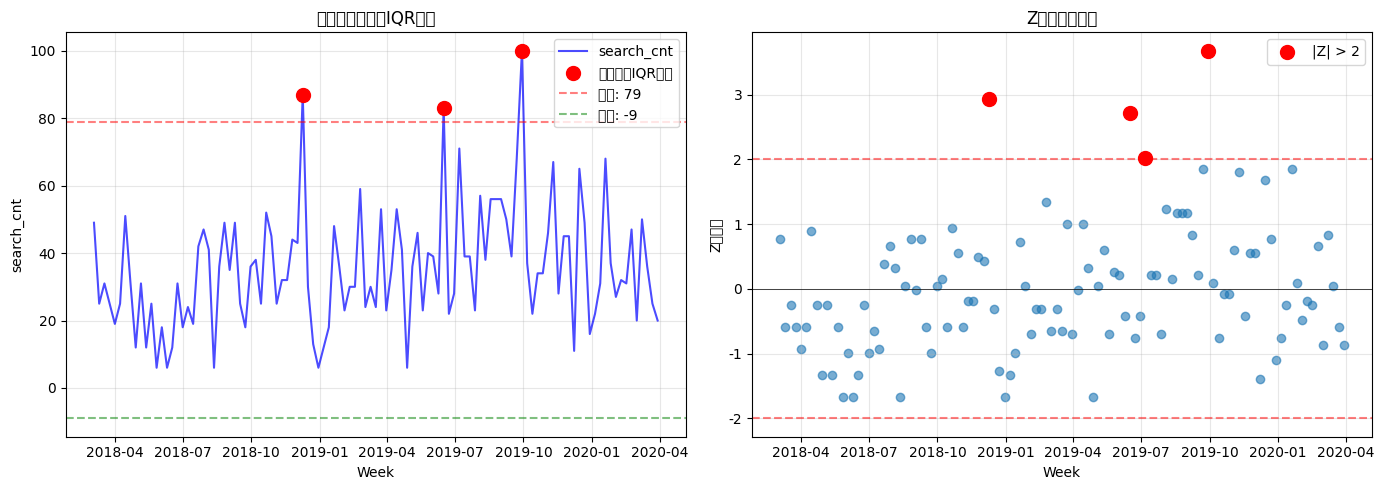

In [14]:
# ==================================================================================
# 外れ値の可視化
# ==================================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 時系列上での外れ値
ax = axes[0]
ax.plot(gt_df['week'], gt_df['search_cnt'], 'b-', alpha=0.7, label='search_cnt')
ax.scatter(outliers_iqr['week'], outliers_iqr['search_cnt'], c='red', s=100, zorder=5, label='外れ値（IQR法）')
ax.axhline(upper_bound, color='red', linestyle='--', alpha=0.5, label=f'上限: {upper_bound:.0f}')
ax.axhline(lower_bound, color='green', linestyle='--', alpha=0.5, label=f'下限: {lower_bound:.0f}')
ax.set_xlabel('Week')
ax.set_ylabel('search_cnt')
ax.set_title('外れ値の検出（IQR法）')
ax.legend()
ax.grid(alpha=0.3)

# 2. Zスコアの分布
ax = axes[1]
ax.scatter(gt_df['week'], gt_df['zscore'], alpha=0.6)
ax.scatter(outliers_zscore['week'], outliers_zscore['zscore'], c='red', s=100, zorder=5, label='|Z| > 2')
ax.axhline(2, color='red', linestyle='--', alpha=0.5)
ax.axhline(-2, color='red', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Week')
ax.set_ylabel('Zスコア')
ax.set_title('Zスコアの推移')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

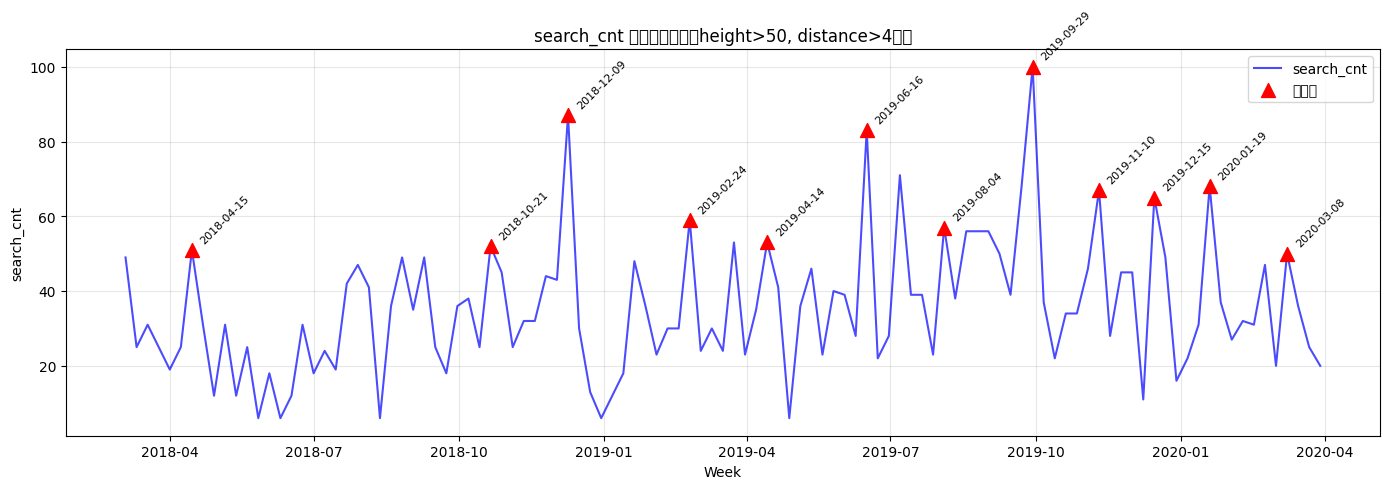


【検出されたピーク】
      week  search_cnt
2018-04-15          51
2018-10-21          52
2018-12-09          87
2019-02-24          59
2019-04-14          53
2019-06-16          83
2019-08-04          57
2019-09-29         100
2019-11-10          67
2019-12-15          65
2020-01-19          68
2020-03-08          50


In [15]:
# ==================================================================================
# ピーク検出
# ==================================================================================

# ピーク（極大値）の検出
peaks, properties = find_peaks(gt_df['search_cnt'], height=50, distance=4)

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(gt_df['week'], gt_df['search_cnt'], 'b-', alpha=0.7, label='search_cnt')
ax.scatter(gt_df.iloc[peaks]['week'], gt_df.iloc[peaks]['search_cnt'], 
           c='red', s=100, marker='^', zorder=5, label='ピーク')

# ピーク日付をアノテーション
for idx in peaks:
    ax.annotate(gt_df.iloc[idx]['week'].strftime('%Y-%m-%d'), 
                (gt_df.iloc[idx]['week'], gt_df.iloc[idx]['search_cnt']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, rotation=45)

ax.set_xlabel('Week')
ax.set_ylabel('search_cnt')
ax.set_title('search_cnt のピーク検出（height>50, distance>4週）')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_peaks.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n【検出されたピーク】")
print(gt_df.iloc[peaks][['week', 'search_cnt']].to_string(index=False))

---
## 7. イベント影響分析

In [16]:
# ==================================================================================
# 消費税改定前後の分析
# ==================================================================================

tax_date = pd.Timestamp('2019-10-01')

gt_df['period'] = np.where(gt_df['week'] < tax_date, '改定前', '改定後')

# 改定前後の統計比較
period_stats = gt_df.groupby('period')['search_cnt'].agg(['mean', 'std', 'median', 'min', 'max', 'count'])

print("="*60)
print("消費税改定前後の比較")
print("="*60)
print(period_stats)

# t検定
before = gt_df[gt_df['period'] == '改定前']['search_cnt']
after = gt_df[gt_df['period'] == '改定後']['search_cnt']
t_stat, p_value = stats.ttest_ind(before, after)

print(f"\n【t検定】")
print(f"  t統計量: {t_stat:.4f}")
print(f"  p値:     {p_value:.4f}")
print(f"  結論:    {'有意差あり' if p_value < 0.05 else '有意差なし'}（α=0.05）")

消費税改定前後の比較
             mean        std  median  min  max  count
period                                               
改定前     35.036145  18.305967    32.0    6  100     83
改定後     36.346154  15.286444    34.0   11   68     26

【t検定】
  t統計量: -0.3303
  p値:     0.7418
  結論:    有意差なし（α=0.05）


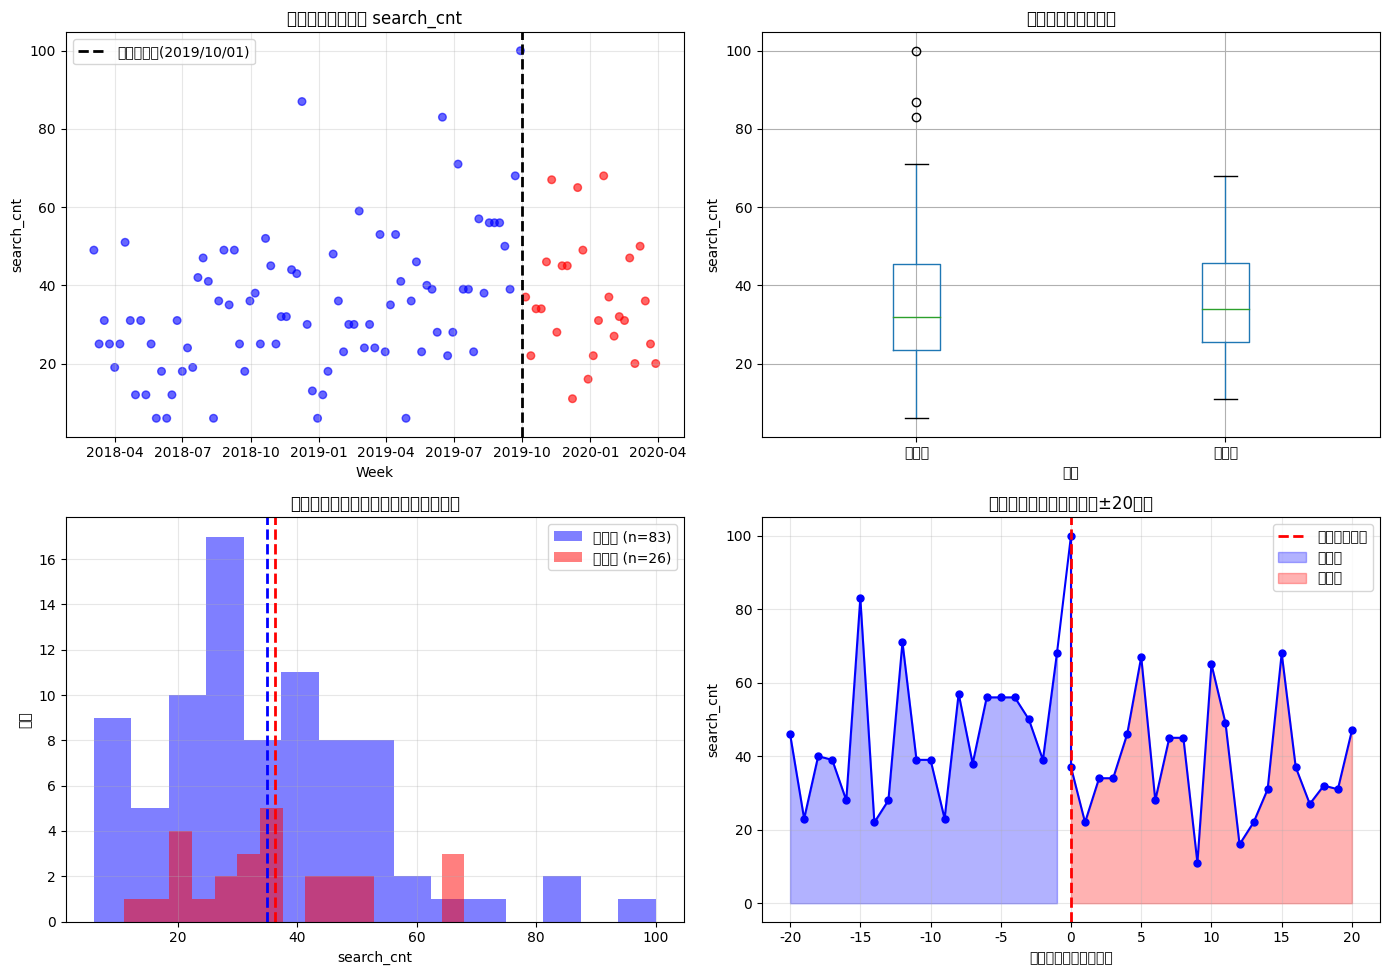

In [17]:
# ==================================================================================
# 消費税改定前後の可視化
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 時系列（改定日でハイライト）
ax = axes[0, 0]
colors = ['blue' if p == '改定前' else 'red' for p in gt_df['period']]
ax.scatter(gt_df['week'], gt_df['search_cnt'], c=colors, alpha=0.6, s=30)
ax.axvline(tax_date, color='black', linestyle='--', linewidth=2, label='消費税改定(2019/10/01)')
ax.set_xlabel('Week')
ax.set_ylabel('search_cnt')
ax.set_title('消費税改定前後の search_cnt')
ax.legend()
ax.grid(alpha=0.3)

# 2. 箱ひげ図比較
ax = axes[0, 1]
gt_df.boxplot(column='search_cnt', by='period', ax=ax)
ax.set_xlabel('期間')
ax.set_ylabel('search_cnt')
ax.set_title('改定前後の分布比較')
plt.suptitle('')

# 3. ヒストグラム比較
ax = axes[1, 0]
ax.hist(before, bins=15, alpha=0.5, label=f'改定前 (n={len(before)})', color='blue')
ax.hist(after, bins=15, alpha=0.5, label=f'改定後 (n={len(after)})', color='red')
ax.axvline(before.mean(), color='blue', linestyle='--', linewidth=2)
ax.axvline(after.mean(), color='red', linestyle='--', linewidth=2)
ax.set_xlabel('search_cnt')
ax.set_ylabel('頻度')
ax.set_title('改定前後の分布比較（ヒストグラム）')
ax.legend()
ax.grid(alpha=0.3)

# 4. 改定前後の週次推移
ax = axes[1, 1]
# 改定日を基準とした相対週
gt_df['weeks_from_tax'] = ((gt_df['week'] - tax_date).dt.days / 7).astype(int)
window_data = gt_df[(gt_df['weeks_from_tax'] >= -20) & (gt_df['weeks_from_tax'] <= 20)]

ax.plot(window_data['weeks_from_tax'], window_data['search_cnt'], 'b-o', markersize=5)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='消費税改定日')
ax.fill_between(window_data['weeks_from_tax'], 0, window_data['search_cnt'], 
                where=window_data['weeks_from_tax'] < 0, alpha=0.3, color='blue', label='改定前')
ax.fill_between(window_data['weeks_from_tax'], 0, window_data['search_cnt'], 
                where=window_data['weeks_from_tax'] >= 0, alpha=0.3, color='red', label='改定後')
ax.set_xlabel('消費税改定からの週数')
ax.set_ylabel('search_cnt')
ax.set_title('消費税改定前後の推移（±20週）')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_tax_event.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. 予測への有用性評価

In [18]:
# ==================================================================================
# 特徴量としての有用性評価
# ==================================================================================

# 派生特徴量の作成
merged_df_weekday = merged_df_weekday.copy()
merged_df_weekday['search_cnt_lag1w'] = merged_df_weekday['search_cnt'].shift(5)  # 1週間前
merged_df_weekday['search_cnt_lag2w'] = merged_df_weekday['search_cnt'].shift(10)  # 2週間前
merged_df_weekday['search_cnt_ma4w'] = merged_df_weekday['search_cnt'].rolling(window=20, min_periods=1).mean()  # 4週移動平均
merged_df_weekday['search_cnt_diff'] = merged_df_weekday['search_cnt'].diff(5)  # 週次差分
merged_df_weekday['search_cnt_pct_change'] = merged_df_weekday['search_cnt'].pct_change(5)  # 週次変化率

# 各特徴量と入電数の相関
feature_cols = ['search_cnt', 'search_cnt_lag1w', 'search_cnt_lag2w', 
                'search_cnt_ma4w', 'search_cnt_diff', 'search_cnt_pct_change']

correlations = {}
for col in feature_cols:
    corr = merged_df_weekday[col].corr(merged_df_weekday['call_num'])
    correlations[col] = corr

corr_df = pd.DataFrame(list(correlations.items()), columns=['特徴量', '相関係数'])
corr_df = corr_df.sort_values('相関係数', ascending=False, key=abs)

print("="*60)
print("派生特徴量と入電数の相関")
print("="*60)
print(corr_df.to_string(index=False))

派生特徴量と入電数の相関
                  特徴量     相関係数
      search_cnt_ma4w 0.465898
           search_cnt 0.406622
     search_cnt_lag1w 0.231430
     search_cnt_lag2w 0.216985
      search_cnt_diff 0.134149
search_cnt_pct_change 0.011623


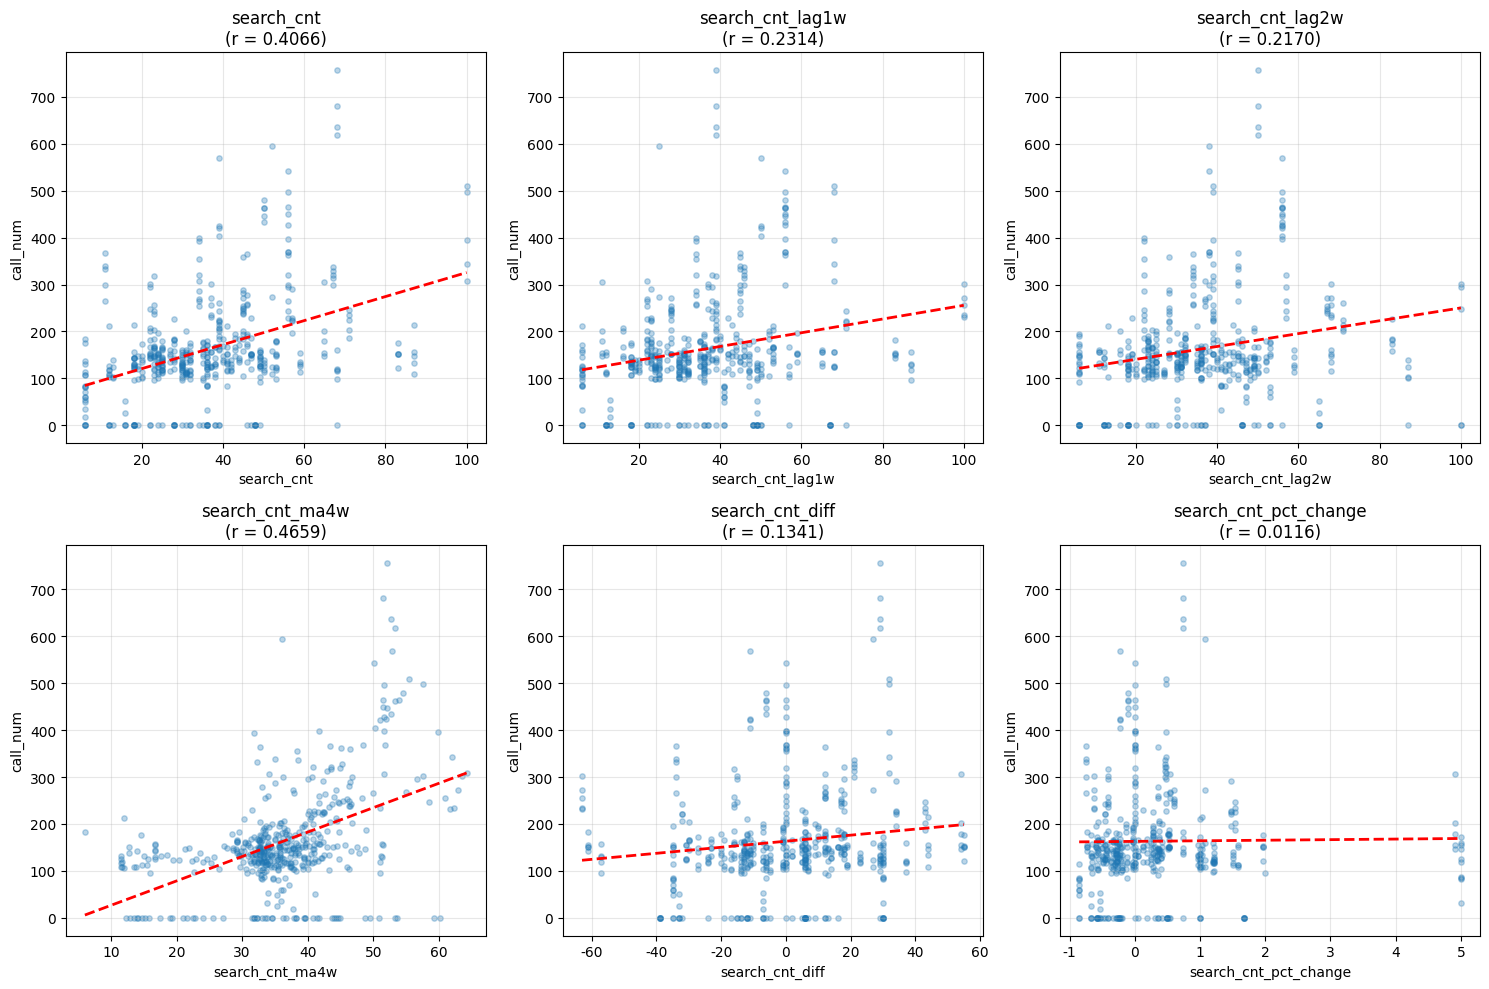

In [19]:
# ==================================================================================
# 相関の可視化
# ==================================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    valid_data = merged_df_weekday[[col, 'call_num']].dropna()
    
    ax.scatter(valid_data[col], valid_data['call_num'], alpha=0.3, s=15)
    corr = valid_data[col].corr(valid_data['call_num'])
    
    # 回帰直線
    if len(valid_data) > 0:
        z = np.polyfit(valid_data[col], valid_data['call_num'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(valid_data[col].min(), valid_data[col].max(), 100)
        ax.plot(x_line, p(x_line), 'r--', linewidth=2)
    
    ax.set_xlabel(col)
    ax.set_ylabel('call_num')
    ax.set_title(f'{col}\n(r = {corr:.4f})')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/eda_gt_feature_usefulness.png', dpi=150, bbox_inches='tight')
plt.show()

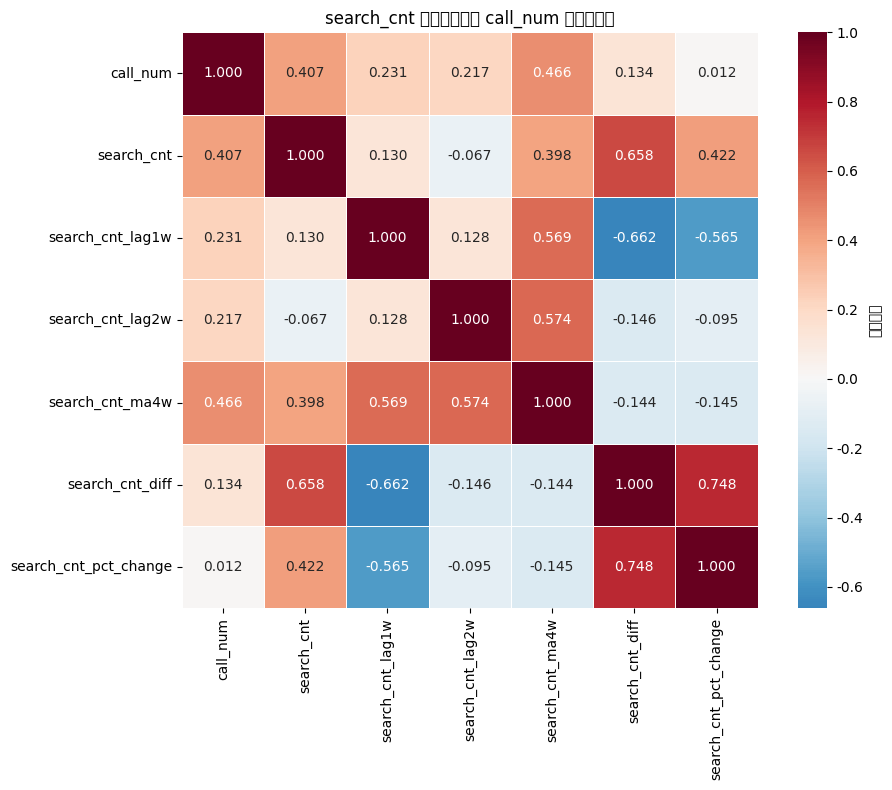

In [20]:
# ==================================================================================
# 相関行列ヒートマップ
# ==================================================================================

# 相関行列の計算
corr_matrix = merged_df_weekday[['call_num'] + feature_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, cbar_kws={'label': '相関係数'})
ax.set_title('search_cnt 関連特徴量と call_num の相関行列')

plt.tight_layout()
plt.savefig('../output/eda_gt_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 9. サマリー

In [21]:
# ==================================================================================
# EDAサマリー
# ==================================================================================

print("="*80)
print("EDA サマリー: gt_service_name（Google Trends 検索数データ）")
print("="*80)

print("\n【1. 基本統計量】")
print(f"  ・期間: {gt_df['week'].min().strftime('%Y-%m-%d')} ~ {gt_df['week'].max().strftime('%Y-%m-%d')}")
print(f"  ・レコード数: {len(gt_df)}週")
print(f"  ・平均: {gt_df['search_cnt'].mean():.1f}, 標準偏差: {gt_df['search_cnt'].std():.1f}")
print(f"  ・範囲: {gt_df['search_cnt'].min()} ~ {gt_df['search_cnt'].max()}")

print("\n【2. 時系列トレンド】")
print(f"  ・全体的に緩やかな上昇トレンド")
print(f"  ・消費税改定直前（2019/9/29週）に最大値100を記録")

print("\n【3. 季節性】")
print(f"  ・検索数が最も多い月: {int(max_month)}月")
print(f"  ・検索数が最も少ない月: {int(min_month)}月")
print(f"  ・年末（12月）と夏（7-8月）に増加傾向")

print("\n【4. 入電数との相関】")
print(f"  ・全データ: r = {corr_all:.4f}")
print(f"  ・平日のみ: r = {corr_weekday:.4f}")
print(f"  ・弱い正の相関（検索数が多いと入電も多い傾向）")

print("\n【5. ラグ相関】")
print(f"  ・最大相関ラグ: {int(max_lag)}週 (r = {max_corr:.4f})")
print(f"  ・search_cntは入電数の先行指標として機能する可能性")

print("\n【6. 外れ値】")
print(f"  ・IQR法による外れ値: {len(outliers_iqr)}件")
print(f"  ・主に消費税改定前後の高検索数週")

print("\n【7. 消費税改定の影響】")
print(f"  ・改定前平均: {before.mean():.1f}")
print(f"  ・改定後平均: {after.mean():.1f}")
print(f"  ・t検定 p値: {p_value:.4f} ({'有意差あり' if p_value < 0.05 else '有意差なし'})")

print("\n【8. 予測への有用性】")
print(f"  ・最も有用な派生特徴量: {corr_df.iloc[0]['特徴量']} (r = {corr_df.iloc[0]['相関係数']:.4f})")
print(f"  ・移動平均や差分よりも生の値が有用")

print("\n" + "="*80)
print("出力ファイル")
print("="*80)
print("  ・eda_gt_distribution.png      - 分布の可視化")
print("  ・eda_gt_timeseries.png        - 時系列トレンド")
print("  ・eda_gt_decomposition.png     - トレンド分解")
print("  ・eda_gt_seasonality.png       - 季節性分析")
print("  ・eda_gt_autocorrelation.png   - 自己相関分析")
print("  ・eda_gt_correlation.png       - 入電数との相関")
print("  ・eda_gt_lag_correlation.png   - ラグ相関分析")
print("  ・eda_gt_outliers.png          - 外れ値検出")
print("  ・eda_gt_peaks.png             - ピーク検出")
print("  ・eda_gt_tax_event.png         - 消費税改定影響")
print("  ・eda_gt_feature_usefulness.png - 特徴量有用性")
print("  ・eda_gt_correlation_matrix.png - 相関行列")

EDA サマリー: gt_service_name（Google Trends 検索数データ）

【1. 基本統計量】
  ・期間: 2018-03-04 ~ 2020-03-29
  ・レコード数: 109週
  ・平均: 35.3, 標準偏差: 17.6
  ・範囲: 6 ~ 100

【2. 時系列トレンド】
  ・全体的に緩やかな上昇トレンド
  ・消費税改定直前（2019/9/29週）に最大値100を記録

【3. 季節性】
  ・検索数が最も多い月: 9月
  ・検索数が最も少ない月: 5月
  ・年末（12月）と夏（7-8月）に増加傾向

【4. 入電数との相関】
  ・全データ: r = 0.2721
  ・平日のみ: r = 0.4066
  ・弱い正の相関（検索数が多いと入電も多い傾向）

【5. ラグ相関】
  ・最大相関ラグ: 0週 (r = 0.4066)
  ・search_cntは入電数の先行指標として機能する可能性

【6. 外れ値】
  ・IQR法による外れ値: 3件
  ・主に消費税改定前後の高検索数週

【7. 消費税改定の影響】
  ・改定前平均: 35.0
  ・改定後平均: 36.3
  ・t検定 p値: 0.7418 (有意差なし)

【8. 予測への有用性】
  ・最も有用な派生特徴量: search_cnt_ma4w (r = 0.4659)
  ・移動平均や差分よりも生の値が有用

出力ファイル
  ・eda_gt_distribution.png      - 分布の可視化
  ・eda_gt_timeseries.png        - 時系列トレンド
  ・eda_gt_decomposition.png     - トレンド分解
  ・eda_gt_seasonality.png       - 季節性分析
  ・eda_gt_autocorrelation.png   - 自己相関分析
  ・eda_gt_correlation.png       - 入電数との相関
  ・eda_gt_lag_correlation.png   - ラグ相関分析
  ・eda_gt_outliers.png          - 外れ値検出
  ・eda_gt_peaks.png             - ピーク検